In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
try:
    import mxnet as mx
except:
    sys.stderr.write("Cannot import mxnet.\n")
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.exposure import rescale_intensity
from skimage.transform import rotate

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *
from visualization_utilities import *

/home/alexn/brainDev/src//utilities/utilities2015.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-pa

Setting environment for Precision WorkStation for Alex Newberry
{'MD589': 0.46, 'MD585': 0.46, 'UCSD001': 0.325}
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_cropbox.ini
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_cropbox.ini
/media/alexn/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/UCSD001/UCSD001_cropbox.ini


Seems you are using operation INIs to provide cropbox.
Seems you are using operation INIs to provide cropbox.
Seems you are using operation INIs to provide cropbox.
Seems you are using operation INIs to provide cropbox.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

In [3]:
batch_size = 256
model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model, mean_img = load_mxnet_model(model_dir_name=model_dir_name, model_name=model_name, 
                                   num_gpus=1, batch_size=batch_size)

ENABLE_DOWNLOAD_S3 is False. Skip downloading from S3.
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:53: UserWarning: You created Module with Module(..., label_names=['softmax_label']) but input with name 'softmax_label' is not found in symbol.list_arguments(). Did you mean one of:
	data
  warnings.warn(msg)
/usr/local/lib/python2.7/dist-packages/mxnet/module/base_module.py:65: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [4]:
#train_stacks = ['MD589', 'MD585']
train_stacks = ['MD585']
#test_stacks = ['MD594']
test_stacks = ['MD585']

In [5]:
stack_stain = {'MD585': 'N', 'MD589': 'N', 'MD594': 'N'}

# Number of sections on which to sample examples from.
stack_section_number = defaultdict(dict)

for name_u in all_known_structures:
    for st in train_stacks:
        stack_section_number[st][name_u] = 10
#         if name_u == '4N' or name_u == '10N':
#             stack_section_number[st][name_u] = 20
#         else:
#             stack_section_number[st][name_u] = 10
    for st in test_stacks:
        stack_section_number[st][name_u] = 10

stack_section_number.default_factory = None

In [6]:
windowing_settings

{1: {'patch_size': 224, 'spacing': 56},
 2: {'comment': 'larger margin', 'patch_size': 224, 'spacing': 56},
 3: {'comment': 'smaller spacing', 'patch_size': 224, 'spacing': 32},
 4: {'comment': 'smaller spacing', 'patch_size': 224, 'spacing': 128},
 5: {'comment': 'smaller spacing', 'patch_size': 224, 'spacing': 64},
 6: {'comment': 'twice as large patch', 'patch_size': 448, 'spacing': 64},
 7: {'comment': 'specify size/spacing in terms of microns rather than pixels',
  'patch_size_um': 103.04,
  'spacing_um': 30},
 8: {'comment': 'larger patch', 'patch_size_um': 206.08, 'spacing_um': 30},
 9: {'comment': 'larger patch', 'patch_size_um': 412.16, 'spacing_um': 30},
 10: {'comment': 'larger patch', 'patch_size_um': 824.32, 'spacing_um': 30},
 11: {'comment': 'larger patch', 'patch_size_um': 51.52, 'spacing_um': 30},
 12: {'comment': 'larger patch', 'patch_size_um': 25.76, 'spacing_um': 30}}

In [7]:
# win_id = 7
# win_id = 8
win_id = 12
# win_id = 11
# win_id = 8

In [8]:
grid_indices_lookup_allStacks = {}

for stack in train_stacks + test_stacks:
#     try:
#         grid_indices_lookup_allStacks[stack] = \
#         DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
#                                                            by_human=False, timestamp='latest',
#                                                            detector_id_f=1,
#                                                           return_locations=True)            

#         grid_indices_lookup_allStacks[stack] = \
#         DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
#                                                            by_human=True, timestamp='latest',
#                                                           return_locations=True, suffix='structures')            

    grid_indices_lookup_allStacks[stack] = \
    DataManager.load_annotation_to_grid_indices_lookup(stack=stack, win_id=win_id,
                                                       by_human=True, timestamp='latest',
                                                      return_locations=True)

#     except Exception as e:
#         sys.stderr.write("Fail to load annotation grid lookup for %s: %s\n" % (stack, e.message))
#         raise e

ENABLE_DOWNLOAD_S3 is False. Skip downloading from S3.
ENABLE_DOWNLOAD_S3 is False. Skip downloading from S3.


MD585_annotation_grid_indices.h5
MD585_annotation_contours_05302018161849.hdf
MD585_annotation_v3.h5
MD585_annotation_win12_05302018161849_grid_indices_lookup.hdf
MD585_annotation_win7_08012017212649_grid_indices_lookup.hdf
MD585_annotation_win7_08012017212649_grid_indices_lookup.hdf None
latest timestamp:  05302018161849


ENABLE_DOWNLOAD_S3 is False. Skip downloading from S3.
ENABLE_DOWNLOAD_S3 is False. Skip downloading from S3.


MD585_annotation_grid_indices.h5
MD585_annotation_contours_05302018161849.hdf
MD585_annotation_v3.h5
MD585_annotation_win12_05302018161849_grid_indices_lookup.hdf
MD585_annotation_win7_08012017212649_grid_indices_lookup.hdf
MD585_annotation_win7_08012017212649_grid_indices_lookup.hdf None
latest timestamp:  05302018161849


In [13]:
grid_indices_lookup_allStacks[stack]['10N'][179]

[array([12703,  7763]),
 array([12768,  7763]),
 array([12768,  7828]),
 array([12833,  7763]),
 array([12833,  7828]),
 array([12898,  7828]),
 array([12898,  7893]),
 array([12963,  7828]),
 array([12963,  7893]),
 array([12963,  7958]),
 array([13028,  7893]),
 array([13028,  7958]),
 array([13028,  8023]),
 array([13093,  7893]),
 array([13093,  7958]),
 array([13093,  8023]),
 array([13158,  7958]),
 array([13158,  8023]),
 array([13158,  8088]),
 array([13223,  7958]),
 array([13223,  8023]),
 array([13223,  8088]),
 array([13288,  8023]),
 array([13288,  8088]),
 array([13288,  8153]),
 array([13353,  8088]),
 array([13353,  8153]),
 array([13418,  8153]),
 array([13418,  8218]),
 array([13483,  8153]),
 array([13483,  8218])]

In [10]:
from itertools import chain
all_labels = sorted(list(set(chain.from_iterable(set(grid_indices_lookup_allStacks[st].columns.tolist()) 
                                                 for st in train_stacks + test_stacks))))

In [11]:
def sample_addresses(stacks, structure):
        
    positive_labels = [structure]
    negative_labels = get_negative_labels(structure, 'neg_has_all_surround', 
                                          margin='500um', labels_found=all_labels)

    positive_addresses_all_stacks = {}
    negative_addresses_all_stacks = {}
        
    for stack in stacks:

        candidate_sections = list(chain(*[grid_indices_lookup_allStacks[stack][pl].dropna(how='any').index.tolist() 
                                      for pl in positive_labels]))

        n_sections = stack_section_number[stack][structure]

        if stack_stain[stack] == 'F':
            neurotrace_sections = []
            nissl_sections = []
            for sec in candidate_sections:
                if (metadata_cache['sections_to_filenames'][stack][sec].split('-')[1][0] == 'F') \
                or stack in ['CHATM2', 'CHATM3']:
                    neurotrace_sections.append(sec)
                else:
                    nissl_sections.append(sec)
            print 'neurotrace_sections', neurotrace_sections
            print 'nissl_sections', nissl_sections
            sampled_sections = np.random.choice(neurotrace_sections, min(len(neurotrace_sections), n_sections), replace=False)
        else:
            sampled_sections = np.random.choice(candidate_sections, min(len(candidate_sections), n_sections), replace=False)
            
        positive_addresses_all_stacks[stack] = sorted([(stack, sec, tuple(loc))
for nl in set(positive_labels) & set(grid_indices_lookup_allStacks[stack].columns)
  for sec, locs in grid_indices_lookup_allStacks[stack][nl].loc[sampled_sections].dropna().iteritems()
  for loc in locs])

        negative_addresses_all_stacks[stack] = sorted([(stack, sec, tuple(loc))
for nl in set(negative_labels) & set(grid_indices_lookup_allStacks[stack].columns)
  for sec, locs in grid_indices_lookup_allStacks[stack][nl].loc[sampled_sections].dropna().iteritems()
  for loc in locs])

    positive_addresses = sum(positive_addresses_all_stacks.values(), [])
    negative_addresses = sum(negative_addresses_all_stacks.values(), [])

    del positive_addresses_all_stacks, negative_addresses_all_stacks

    return positive_addresses, negative_addresses

In [12]:
# train_scheme = 'stretch_min_max'
# train_scheme = 'normalize_mu_sigma_global_(-1,5)'
# train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
# train_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
train_scheme = 'none'

# test_scheme = 'stretch_min_max'
# test_scheme = 'normalize_mu_sigma_global_(-1,5)'
# test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,5)'
# test_scheme = 'normalize_mu_region_sigma_wholeImage_(-1,9)'
test_scheme = 'none'

In [13]:
# existing_classifier_id = 998 # If set, not train from scratch
# existing_classifier_id = 990
# extract_train_features = True

In [14]:
existing_classifier_id = None
extract_train_features = True
# classifier_id = 990 # MD585/MD589 -> MD594, cnn
# classifier_id = 991 # MD585/MD589 -> MD594, lbp
# classifier_id = 992 # MD585/MD589 -> MD594, glcm
# classifier_id = 993 # MD585/MD589 -> MD594, mean greylevel
# classifier_id = 899 # CHATM2 -> CHATM2, cnn
# classifier_id = 898 # DEMO998 -> DEMO998, cnn, win7
# classifier_id = 897 # DEMO998 -> DEMO998, cnn, win8
# classifier_id = 896 # DEMO998 -> DEMO998, cnn, win9
# win10 is too large and no patch can be extracted from DEMO998 section 225 3N.
# classifier_id = 895 # DEMO998 -> DEMO998, cnn, win11
# classifier_id = 894 # MD585/MD589 -> MD594, cnn, win8
# classifier_id = 893 # MD585/MD589 -> MD594, cnn, win11
# classifier_id = 892 # MD585/MD589 -> MD594, cnn, concat 100um 200um
# classifier_id = 891 # MD585/MD589 -> MD594, cnn, win7
# classifier_id = 890 # MD585/MD589 -> MD594, cnn, concat 100um 200um 50um
classifier_id = 889 # MD585/MD589 -> MD594, cnn, win9

In [15]:
# method = 'mean_intensity'
method = 'cnn' # 

In [16]:
prep_id = 'alignedBrainstemCrop'

In [ ]:
for stack in ['MD585', 'MD589', 'MD594']:
    
    target_locations = grid_parameters_to_sample_locations(grid_spec=win_id_to_gridspec(win_id=7, stack=stack))
    source_locations = grid_parameters_to_sample_locations(grid_spec=win_id_to_gridspec(win_id=8, stack=stack))
    target_locations_mapped_to_source_locations, target_indices_to_source_indices_mapping = align_grid_specs(source_locations=source_locations, target_locations=target_locations, stack=stack)

    target_locations_to_source_locations_mapping = {tuple(tgt_loc): tuple(src_loc)
                        for tgt_loc, src_loc in zip(target_locations, target_locations_mapped_to_source_locations)}
    
    for sec in metadata_cache['valid_sections'][stack]:
        
        print stack, sec
        
        features_100um, locations_100um = DataManager.load_dnn_features_v2(stack=stack, sec=sec,
                                                                           prep_id=prep_id, win_id=7,
                                                                           normalization_scheme='none',
                                                                           model_name=model_name)
        
        features_200um, locations_200um = DataManager.load_dnn_features_v2(stack=stack, sec=sec,
                                                               prep_id=prep_id, win_id=8,
                                                               normalization_scheme='none',
                                                               model_name=model_name)

        locations_200um_to_indices_200um_in_loaded_pool_mapping = {tuple(loc_200um): idx_200um_in_loaded_pool
                                for idx_200um_in_loaded_pool, loc_200um in enumerate(locations_200um)}
        
        features = []
        locations = []
        for idx_100um_in_loaded_pool, loc_100um in enumerate(locations_100um):
            loc_200um = target_locations_to_source_locations_mapping[tuple(loc_100um)]
            if tuple(loc_200um) in locations_200um_to_indices_200um_in_loaded_pool_mapping:
                # check if the 100um grid mapped to a 200um grid that has features associated
                idx_200um_in_loaded_pool = locations_200um_to_indices_200um_in_loaded_pool_mapping[tuple(loc_200um)]

                f = np.concatenate([features_100um[idx_100um_in_loaded_pool], 
                                   features_200um[idx_200um_in_loaded_pool]], axis=-1)
                features.append(f)
                locations.append(locations_100um[idx_100um_in_loaded_pool])
                
        DataManager.save_dnn_features_v2(features=features, locations=locations,
                         stack=stack, sec=sec, prep_id=prep_id,
                         win_id=7, normalization_scheme='none',
                         model_name='concat_100um_200um')

In [ ]:
for stack in ['MD585', 'MD589', 'MD594']:
    
    size100um_locations = grid_parameters_to_sample_locations(grid_spec=win_id_to_gridspec(win_id=7, stack=stack))
    size200um_locations = grid_parameters_to_sample_locations(grid_spec=win_id_to_gridspec(win_id=8, stack=stack))
    size50um_locations = grid_parameters_to_sample_locations(grid_spec=win_id_to_gridspec(win_id=11, stack=stack))
    
    size100um_locations_mapped_to_size200um_locations, \
    size100um_indices_to_size200um_indices_mapping = \
    align_grid_specs(source_locations=size200um_locations, 
                     target_locations=size100um_locations, 
                     stack=stack)

    size100um_locations_to_size200um_locations_mapping = {tuple(tgt_loc): tuple(src_loc)
                        for tgt_loc, src_loc in zip(size100um_locations, 
                                                    size100um_locations_mapped_to_size200um_locations)}
    
    size100um_locations_mapped_to_size50um_locations, \
    size100um_indices_to_size50um_indices_mapping = \
    align_grid_specs(source_locations=size50um_locations, 
                     target_locations=size100um_locations, 
                     stack=stack)
    size100um_locations_to_size50um_locations_mapping = {tuple(tgt_loc): tuple(src_loc)
                        for tgt_loc, src_loc in zip(size100um_locations, 
                                                    size100um_locations_mapped_to_size50um_locations)}
    
    for sec in metadata_cache['valid_sections'][stack]:
        
        print stack, sec
        
        features_100um, locations_100um = DataManager.load_dnn_features_v2(stack=stack, sec=sec,
                                                                           prep_id=prep_id, win_id=7,
                                                                           normalization_scheme='none',
                                                                           model_name=model_name)
        
        features_200um, locations_200um = DataManager.load_dnn_features_v2(stack=stack, sec=sec,
                                                               prep_id=prep_id, win_id=8,
                                                               normalization_scheme='none',
                                                               model_name=model_name)

        features_50um, locations_50um = DataManager.load_dnn_features_v2(stack=stack, sec=sec,
                                                               prep_id=prep_id, win_id=11,
                                                               normalization_scheme='none',
                                                               model_name=model_name)

        locations_200um_to_indices_200um_in_loaded_pool_mapping = {tuple(loc_200um): idx_200um_in_loaded_pool
                                for idx_200um_in_loaded_pool, loc_200um in enumerate(locations_200um)}

        locations_50um_to_indices_50um_in_loaded_pool_mapping = {tuple(loc_50um): idx_50um_in_loaded_pool
                        for idx_50um_in_loaded_pool, loc_50um in enumerate(locations_50um)}

        
        features = []
        locations = []
        for idx_100um_in_loaded_pool, loc_100um in enumerate(locations_100um):
            loc_200um = size100um_locations_to_size200um_locations_mapping[tuple(loc_100um)]
            loc_50um = size100um_locations_to_size50um_locations_mapping[tuple(loc_100um)]
            
            if tuple(loc_200um) in locations_200um_to_indices_200um_in_loaded_pool_mapping and \
            tuple(loc_50um) in locations_50um_to_indices_50um_in_loaded_pool_mapping:
                
                # check if the 100um grid mapped to a 200um grid that has features associated
                idx_200um_in_loaded_pool = locations_200um_to_indices_200um_in_loaded_pool_mapping[tuple(loc_200um)]
                
                idx_50um_in_loaded_pool = locations_50um_to_indices_50um_in_loaded_pool_mapping[tuple(loc_50um)]

                f = np.concatenate([features_100um[idx_100um_in_loaded_pool], 
                                   features_200um[idx_200um_in_loaded_pool],
                                   features_50um[idx_50um_in_loaded_pool]], axis=-1)
                features.append(f)
                locations.append(locations_100um[idx_100um_in_loaded_pool])
                
        DataManager.save_dnn_features_v2(features=features, locations=locations,
                         stack=stack, sec=sec, prep_id=prep_id,
                         win_id=7, normalization_scheme='none',
                         model_name='concat_100um_200um_50um')

In [18]:
compute_new_addresses = False

In [317]:
# model_name = 'concat_100um_200um'
model_name = 'concat_100um_200um_50um'

# positive train = 4215
# negative train = 28745
('MD589', 105)
('MD589', 350)
('MD585', 343)


Feature for (MD585,343,(6818,7598)) is not in pool. Re-compute.
Feature for (MD585,343,(6818,7663)) is not in pool. Re-compute.
Feature for (MD585,343,(6883,7598)) is not in pool. Re-compute.
Feature for (MD585,343,(6883,7663)) is not in pool. Re-compute.
Feature for (MD585,343,(6883,7728)) is not in pool. Re-compute.
Feature for (MD585,343,(6948,7533)) is not in pool. Re-compute.
Feature for (MD585,343,(6948,7598)) is not in pool. Re-compute.
Feature for (MD585,343,(6948,7663)) is not in pool. Re-compute.
Feature for (MD585,343,(6948,7728)) is not in pool. Re-compute.
Feature for (MD585,343,(7013,7533)) is not in pool. Re-compute.
Feature for (MD585,343,(7013,7598)) is not in pool. Re-compute.
Feature for (MD585,343,(7013,7663)) is not in pool. Re-compute.
Feature for (MD585,343,(7013,7728)) is not in pool. Re-compute.
Feature for (MD585,343,(7013,7793)) is not in pool. Re-compute.
Feature for (MD585,343,(7078,7598)) is not in pool. Re-compute.
Feature for (MD585,343,(7078,7663)) is n

('MD589', 104)
('MD585', 88)


Feature for (MD585,88,(6363,8183)) is not in pool. Re-compute.
Feature for (MD585,88,(6363,8248)) is not in pool. Re-compute.
Feature for (MD585,88,(6428,8183)) is not in pool. Re-compute.
Feature for (MD585,88,(6428,8248)) is not in pool. Re-compute.
Feature for (MD585,88,(6428,8313)) is not in pool. Re-compute.
Feature for (MD585,88,(6428,8378)) is not in pool. Re-compute.
Feature for (MD585,88,(6493,8183)) is not in pool. Re-compute.
Feature for (MD585,88,(6493,8248)) is not in pool. Re-compute.
Feature for (MD585,88,(6493,8313)) is not in pool. Re-compute.
Feature for (MD585,88,(6493,8378)) is not in pool. Re-compute.
Feature for (MD585,88,(6493,8443)) is not in pool. Re-compute.
Feature for (MD585,88,(6558,8183)) is not in pool. Re-compute.
Feature for (MD585,88,(6558,8248)) is not in pool. Re-compute.
Feature for (MD585,88,(6558,8313)) is not in pool. Re-compute.
Feature for (MD585,88,(6558,8378)) is not in pool. Re-compute.
Feature for (MD585,88,(6558,8443)) is not in pool. Re-c

('MD589', 102)
('MD585', 95)


Feature for (MD585,95,(5973,8183)) is not in pool. Re-compute.
Feature for (MD585,95,(5973,8248)) is not in pool. Re-compute.
Feature for (MD585,95,(5973,8313)) is not in pool. Re-compute.
Feature for (MD585,95,(6038,8183)) is not in pool. Re-compute.
Feature for (MD585,95,(6038,8248)) is not in pool. Re-compute.
Feature for (MD585,95,(6038,8313)) is not in pool. Re-compute.
Feature for (MD585,95,(6103,8183)) is not in pool. Re-compute.
Feature for (MD585,95,(6103,8248)) is not in pool. Re-compute.
Feature for (MD585,95,(6103,8313)) is not in pool. Re-compute.
Feature for (MD585,95,(6168,8118)) is not in pool. Re-compute.
Feature for (MD585,95,(6168,8183)) is not in pool. Re-compute.
Feature for (MD585,95,(6168,8248)) is not in pool. Re-compute.
Feature for (MD585,95,(6168,8313)) is not in pool. Re-compute.
Feature for (MD585,95,(6233,8248)) is not in pool. Re-compute.
Feature for (MD585,95,(6233,8313)) is not in pool. Re-compute.
Feature for (MD585,95,(6298,8313)) is not in pool. Re-c

('MD589', 348)
('MD589', 339)
('MD585', 331)
('MD589', 362)
('MD589', 354)
('MD589', 109)
('MD589', 351)
('MD585', 328)
('MD585', 325)
('MD585', 100)
('MD585', 334)


Feature for (MD585,334,(6493,7793)) is not in pool. Re-compute.
Feature for (MD585,334,(6558,7858)) is not in pool. Re-compute.
Feature for (MD585,334,(6623,7858)) is not in pool. Re-compute.


('MD585', 347)


Feature for (MD585,347,(7078,7663)) is not in pool. Re-compute.
Feature for (MD585,347,(7143,7663)) is not in pool. Re-compute.
Feature for (MD585,347,(7143,7728)) is not in pool. Re-compute.
Feature for (MD585,347,(7208,7598)) is not in pool. Re-compute.
Feature for (MD585,347,(7208,7663)) is not in pool. Re-compute.
Feature for (MD585,347,(7208,7728)) is not in pool. Re-compute.
Feature for (MD585,347,(7273,7598)) is not in pool. Re-compute.
Feature for (MD585,347,(7273,7663)) is not in pool. Re-compute.
Feature for (MD585,347,(7273,7728)) is not in pool. Re-compute.
Feature for (MD585,347,(7273,7793)) is not in pool. Re-compute.
Feature for (MD585,347,(7338,7598)) is not in pool. Re-compute.
Feature for (MD585,347,(7338,7663)) is not in pool. Re-compute.
Feature for (MD585,347,(7338,7728)) is not in pool. Re-compute.
Feature for (MD585,347,(7338,7793)) is not in pool. Re-compute.
Feature for (MD585,347,(7403,7598)) is not in pool. Re-compute.
Feature for (MD585,347,(7403,7663)) is n

('MD585', 336)


Feature for (MD585,336,(6428,7663)) is not in pool. Re-compute.
Feature for (MD585,336,(6428,7728)) is not in pool. Re-compute.
Feature for (MD585,336,(6493,7533)) is not in pool. Re-compute.
Feature for (MD585,336,(6493,7598)) is not in pool. Re-compute.
Feature for (MD585,336,(6493,7663)) is not in pool. Re-compute.
Feature for (MD585,336,(6493,7728)) is not in pool. Re-compute.
Feature for (MD585,336,(6493,7793)) is not in pool. Re-compute.
Feature for (MD585,336,(6493,7858)) is not in pool. Re-compute.
Feature for (MD585,336,(6558,7468)) is not in pool. Re-compute.
Feature for (MD585,336,(6558,7533)) is not in pool. Re-compute.
Feature for (MD585,336,(6558,7598)) is not in pool. Re-compute.
Feature for (MD585,336,(6558,7663)) is not in pool. Re-compute.
Feature for (MD585,336,(6558,7728)) is not in pool. Re-compute.
Feature for (MD585,336,(6558,7793)) is not in pool. Re-compute.
Feature for (MD585,336,(6558,7858)) is not in pool. Re-compute.
Feature for (MD585,336,(6558,7923)) is n

# positive test = 1735
# negative test = 15286
('MD594', 99)
('MD594', 340)
('MD594', 335)
('MD594', 346)
('MD594', 111)
('MD594', 115)
('MD594', 360)
('MD594', 102)
('MD594', 348)
('MD594', 351)
n_train 1000
Trial 0
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.58 seconds


Trial 1
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.57 seconds


Trial 2
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.56 seconds


n_train 5000
Trial 0
Training: 4215 positive, 4215 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.45 seconds


Trial 1
Training: 4215 positive, 4215 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 3.19 seconds


Trial 2
Training: 4215 positive, 4215 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.90 seconds


n_train 15000
Trial 0
Training: 4215 positive, 4215 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 3.16 seconds


Trial 1
Training: 4215 positive, 4215 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 3.14 seconds


Trial 2
Training: 4215 positive, 4215 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.46 seconds


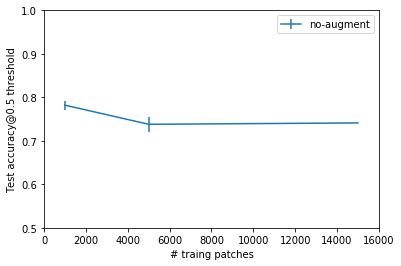

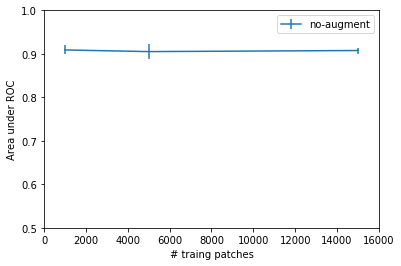

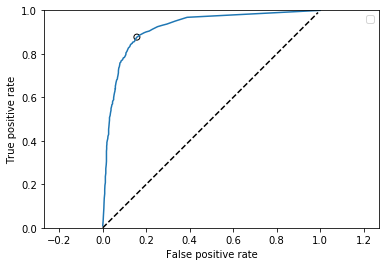

# positive train = 1660
# negative train = 24703
('MD585', 333)
('MD589', 121)
('MD589', 115)
('MD585', 324)
('MD585', 323)
('MD585', 99)
('MD589', 348)
('MD589', 347)
('MD585', 95)


Feature for (MD585,95,(6818,8638)) is not in pool. Re-compute.
Feature for (MD585,95,(6818,8703)) is not in pool. Re-compute.
Feature for (MD585,95,(6818,8768)) is not in pool. Re-compute.
Feature for (MD585,95,(6883,8703)) is not in pool. Re-compute.
Feature for (MD585,95,(6883,8768)) is not in pool. Re-compute.
Feature for (MD585,95,(6883,8833)) is not in pool. Re-compute.
Feature for (MD585,95,(6883,8898)) is not in pool. Re-compute.
Feature for (MD585,95,(6948,8833)) is not in pool. Re-compute.
Feature for (MD585,95,(6948,8898)) is not in pool. Re-compute.


('MD589', 346)
('MD585', 96)


Feature for (MD585,96,(6948,8768)) is not in pool. Re-compute.
Feature for (MD585,96,(6948,8833)) is not in pool. Re-compute.
Feature for (MD585,96,(7013,8898)) is not in pool. Re-compute.


('MD585', 93)


Feature for (MD585,93,(6818,8638)) is not in pool. Re-compute.
Feature for (MD585,93,(6818,8703)) is not in pool. Re-compute.
Feature for (MD585,93,(6818,8768)) is not in pool. Re-compute.
Feature for (MD585,93,(6883,8703)) is not in pool. Re-compute.
Feature for (MD585,93,(6883,8768)) is not in pool. Re-compute.
Feature for (MD585,93,(6883,8833)) is not in pool. Re-compute.
Feature for (MD585,93,(6883,8898)) is not in pool. Re-compute.
Feature for (MD585,93,(6883,8963)) is not in pool. Re-compute.
Feature for (MD585,93,(6948,8833)) is not in pool. Re-compute.
Feature for (MD585,93,(6948,8898)) is not in pool. Re-compute.


('MD585', 103)
('MD585', 92)


Feature for (MD585,92,(6883,8833)) is not in pool. Re-compute.
Feature for (MD585,92,(6883,8898)) is not in pool. Re-compute.
Feature for (MD585,92,(6883,8963)) is not in pool. Re-compute.
Feature for (MD585,92,(6948,8833)) is not in pool. Re-compute.
Feature for (MD585,92,(6948,8898)) is not in pool. Re-compute.


('MD589', 354)
('MD589', 353)
('MD585', 320)
('MD589', 341)
('MD589', 344)
('MD589', 351)
# positive test = 937
# negative test = 11830
('MD594', 116)
('MD594', 354)
('MD594', 119)
('MD594', 344)
('MD594', 346)
('MD594', 339)
('MD594', 105)
('MD594', 114)
('MD594', 107)
('MD594', 353)
n_train 1000
Trial 0
Training: 1000 positive, 1000 negative
Test: 937 positive, 1000 negative


Fitting classifier: 0.52 seconds


Trial 1
Training: 1000 positive, 1000 negative
Test: 937 positive, 1000 negative


Fitting classifier: 0.45 seconds


Trial 2
Training: 1000 positive, 1000 negative
Test: 937 positive, 1000 negative


Fitting classifier: 0.47 seconds


n_train 5000
Trial 0
Training: 1660 positive, 1660 negative
Test: 937 positive, 1000 negative


Fitting classifier: 0.84 seconds


Trial 1
Training: 1660 positive, 1660 negative
Test: 937 positive, 1000 negative


Fitting classifier: 0.89 seconds


Trial 2
Training: 1660 positive, 1660 negative
Test: 937 positive, 1000 negative


Fitting classifier: 0.86 seconds


n_train 15000
Trial 0
Training: 1660 positive, 1660 negative
Test: 937 positive, 1000 negative


Fitting classifier: 0.92 seconds


Trial 1
Training: 1660 positive, 1660 negative
Test: 937 positive, 1000 negative


Fitting classifier: 0.80 seconds


Trial 2
Training: 1660 positive, 1660 negative
Test: 937 positive, 1000 negative


Fitting classifier: 0.86 seconds


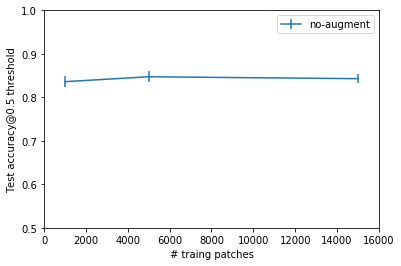

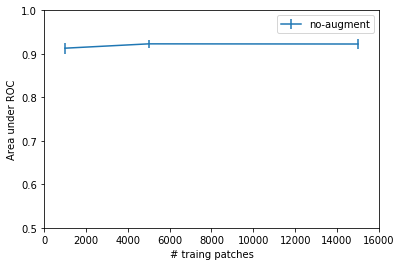

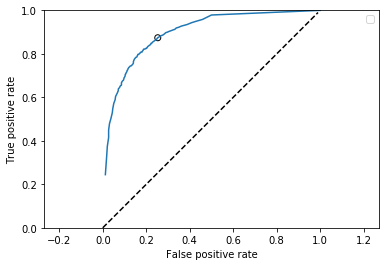

# positive train = 1729
# negative train = 30529
('MD589', 345)
('MD585', 300)
('MD589', 114)
('MD585', 323)
('MD589', 350)
('MD585', 322)
('MD589', 123)
('MD589', 325)
('MD589', 346)
('MD589', 330)
('MD585', 317)
('MD585', 106)
('MD589', 333)
('MD589', 351)
('MD589', 108)
('MD585', 306)
('MD585', 111)
('MD585', 113)
('MD585', 302)
('MD585', 91)
# positive test = 539
# negative test = 14150
('MD594', 323)
('MD594', 347)
('MD594', 112)
('MD594', 115)
('MD594', 324)
('MD594', 134)
('MD594', 124)
('MD594', 106)
('MD594', 351)
('MD594', 128)
n_train 1000
Trial 0
Training: 1000 positive, 1000 negative
Test: 539 positive, 1000 negative


Fitting classifier: 0.50 seconds


Trial 1
Training: 1000 positive, 1000 negative
Test: 539 positive, 1000 negative


Fitting classifier: 0.45 seconds


Trial 2
Training: 1000 positive, 1000 negative
Test: 539 positive, 1000 negative


Fitting classifier: 0.42 seconds


n_train 5000
Trial 0
Training: 1729 positive, 1729 negative
Test: 539 positive, 1000 negative


Fitting classifier: 0.81 seconds


Trial 1
Training: 1729 positive, 1729 negative
Test: 539 positive, 1000 negative


Fitting classifier: 0.86 seconds


Trial 2
Training: 1729 positive, 1729 negative
Test: 539 positive, 1000 negative


Fitting classifier: 0.93 seconds


n_train 15000
Trial 0
Training: 1729 positive, 1729 negative
Test: 539 positive, 1000 negative


Fitting classifier: 0.82 seconds


Trial 1
Training: 1729 positive, 1729 negative
Test: 539 positive, 1000 negative


Fitting classifier: 0.78 seconds


Trial 2
Training: 1729 positive, 1729 negative
Test: 539 positive, 1000 negative


Fitting classifier: 0.80 seconds


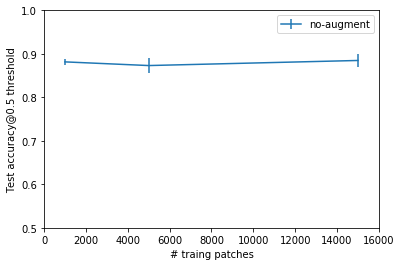

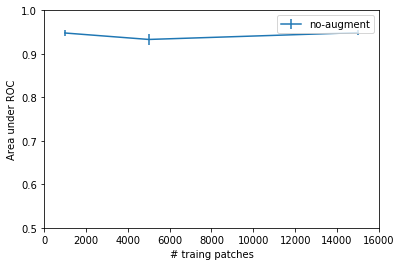

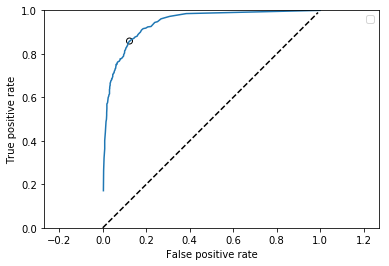

# positive train = 168
# negative train = 16048
('MD589', 222)
('MD585', 204)
('MD585', 195)
('MD589', 220)
('MD589', 224)
('MD585', 194)
('MD589', 219)
('MD589', 229)
('MD589', 227)
('MD585', 203)
('MD589', 228)
('MD585', 202)
('MD585', 199)
('MD589', 225)
('MD585', 201)
('MD585', 200)
('MD585', 197)
('MD585', 196)
('MD589', 223)
('MD589', 230)
# positive test = 90
# negative test = 7070
('MD594', 227)
('MD594', 237)
('MD594', 236)
('MD594', 229)
('MD594', 228)
('MD594', 232)
('MD594', 230)
('MD594', 235)
('MD594', 225)
('MD594', 234)
n_train 1000
Trial 0
Training: 168 positive, 168 negative
Test: 90 positive, 1000 negative


Fitting classifier: 0.05 seconds


Trial 1
Training: 168 positive, 168 negative
Test: 90 positive, 1000 negative


Fitting classifier: 0.04 seconds


Trial 2
Training: 168 positive, 168 negative
Test: 90 positive, 1000 negative


Fitting classifier: 0.04 seconds


n_train 5000
Trial 0
Training: 168 positive, 168 negative
Test: 90 positive, 1000 negative


Fitting classifier: 0.05 seconds


Trial 1
Training: 168 positive, 168 negative
Test: 90 positive, 1000 negative


Fitting classifier: 0.04 seconds


Trial 2
Training: 168 positive, 168 negative
Test: 90 positive, 1000 negative


Fitting classifier: 0.05 seconds


n_train 15000
Trial 0
Training: 168 positive, 168 negative
Test: 90 positive, 1000 negative


Fitting classifier: 0.05 seconds


Trial 1
Training: 168 positive, 168 negative
Test: 90 positive, 1000 negative


Fitting classifier: 0.04 seconds


Trial 2
Training: 168 positive, 168 negative
Test: 90 positive, 1000 negative


Fitting classifier: 0.05 seconds


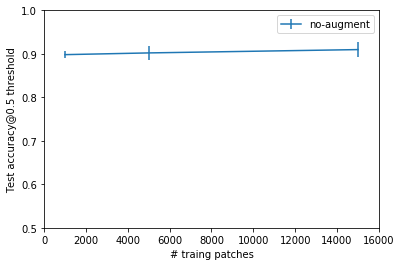

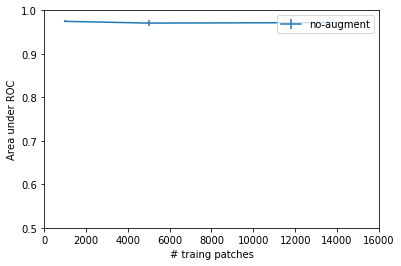

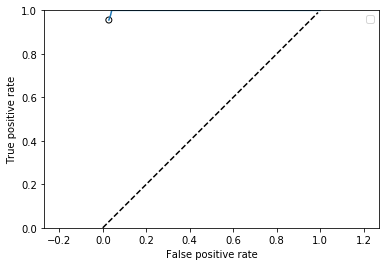

# positive train = 783
# negative train = 31167
('MD585', 205)
('MD585', 218)
('MD589', 208)
('MD585', 185)
('MD585', 214)
('MD589', 231)
('MD585', 184)
('MD585', 194)
('MD585', 216)
('MD589', 229)
('MD589', 236)
('MD589', 206)
('MD589', 227)
('MD585', 188)
('MD589', 230)
('MD589', 214)
('MD585', 207)
('MD585', 196)
('MD589', 223)
('MD589', 242)
# positive test = 343
# negative test = 17171
('MD594', 227)
('MD594', 219)
('MD594', 236)
('MD594', 241)
('MD594', 228)
('MD594', 233)
('MD594', 231)
('MD594', 232)
('MD594', 230)
('MD594', 213)
n_train 1000
Trial 0
Training: 783 positive, 783 negative
Test: 343 positive, 1000 negative


Fitting classifier: 0.28 seconds


Trial 1
Training: 783 positive, 783 negative
Test: 343 positive, 1000 negative


Fitting classifier: 0.30 seconds


Trial 2
Training: 783 positive, 783 negative
Test: 343 positive, 1000 negative


Fitting classifier: 0.28 seconds


n_train 5000
Trial 0
Training: 783 positive, 783 negative
Test: 343 positive, 1000 negative


Fitting classifier: 0.27 seconds


Trial 1
Training: 783 positive, 783 negative
Test: 343 positive, 1000 negative


Fitting classifier: 0.30 seconds


Trial 2
Training: 783 positive, 783 negative
Test: 343 positive, 1000 negative


Fitting classifier: 0.27 seconds


n_train 15000
Trial 0
Training: 783 positive, 783 negative
Test: 343 positive, 1000 negative


Fitting classifier: 0.29 seconds


Trial 1
Training: 783 positive, 783 negative
Test: 343 positive, 1000 negative


Fitting classifier: 0.30 seconds


Trial 2
Training: 783 positive, 783 negative
Test: 343 positive, 1000 negative


Fitting classifier: 0.29 seconds


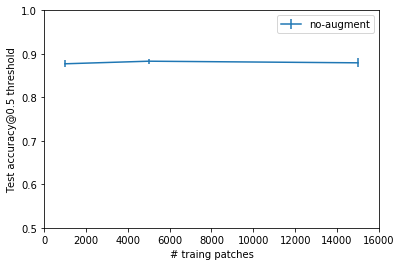

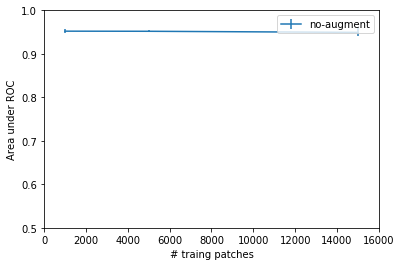

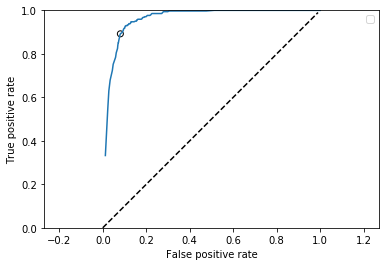

# positive train = 3073
# negative train = 35579
('MD585', 238)
('MD585', 247)
('MD589', 200)
('MD589', 260)
('MD589', 222)
('MD589', 230)
('MD589', 240)
('MD589', 245)
('MD585', 235)
('MD585', 224)
('MD585', 221)
('MD585', 234)
('MD589', 270)
('MD585', 211)
('MD589', 204)
('MD589', 268)
('MD585', 196)
('MD585', 209)
('MD585', 206)
('MD589', 223)
# positive test = 1494
# negative test = 17654
('MD594', 216)
('MD594', 237)
('MD594', 246)
('MD594', 250)
('MD594', 206)
('MD594', 199)
('MD594', 230)
('MD594', 202)
('MD594', 262)
('MD594', 254)
n_train 1000
Trial 0
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.52 seconds


Trial 1
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.46 seconds


Trial 2
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.45 seconds


n_train 5000
Trial 0
Training: 3073 positive, 3073 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.87 seconds


Trial 1
Training: 3073 positive, 3073 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.91 seconds


Trial 2
Training: 3073 positive, 3073 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.99 seconds


n_train 15000
Trial 0
Training: 3073 positive, 3073 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.94 seconds


Trial 1
Training: 3073 positive, 3073 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 1.97 seconds


Trial 2
Training: 3073 positive, 3073 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 2.00 seconds


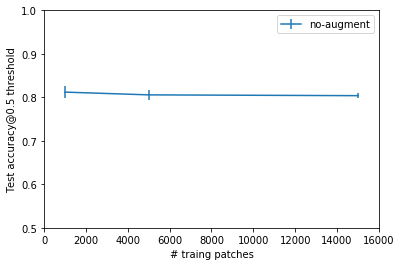

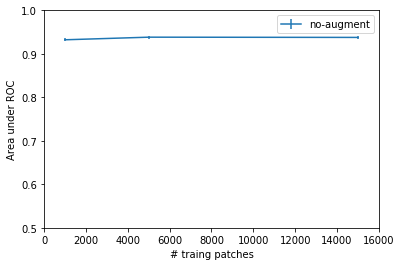

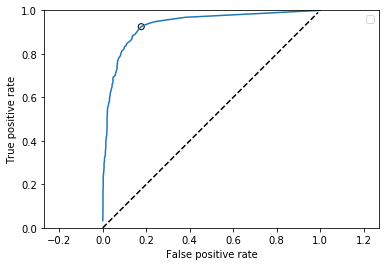

# positive train = 21430
# negative train = 55080
('MD585', 218)


Feature for (MD585,218,(3178,448)) is not in pool. Re-compute.
Feature for (MD585,218,(3243,448)) is not in pool. Re-compute.
Feature for (MD585,218,(3308,448)) is not in pool. Re-compute.
Feature for (MD585,218,(3373,448)) is not in pool. Re-compute.
Feature for (MD585,218,(3438,448)) is not in pool. Re-compute.
Feature for (MD585,218,(3503,448)) is not in pool. Re-compute.
Feature for (MD585,218,(3568,448)) is not in pool. Re-compute.
Feature for (MD585,218,(3633,448)) is not in pool. Re-compute.
Feature for (MD585,218,(3698,448)) is not in pool. Re-compute.
Feature for (MD585,218,(3763,448)) is not in pool. Re-compute.
Feature for (MD585,218,(3828,448)) is not in pool. Re-compute.
Feature for (MD585,218,(3893,448)) is not in pool. Re-compute.
Feature for (MD585,218,(3958,448)) is not in pool. Re-compute.
Feature for (MD585,218,(4023,448)) is not in pool. Re-compute.
Feature for (MD585,218,(4088,448)) is not in pool. Re-compute.
Feature for (MD585,218,(4153,448)) is not in pool. Re-c

('MD585', 204)


Feature for (MD585,204,(3633,448)) is not in pool. Re-compute.
Feature for (MD585,204,(3698,448)) is not in pool. Re-compute.
Feature for (MD585,204,(3763,448)) is not in pool. Re-compute.
Feature for (MD585,204,(3828,448)) is not in pool. Re-compute.
Feature for (MD585,204,(3893,448)) is not in pool. Re-compute.
Feature for (MD585,204,(3958,448)) is not in pool. Re-compute.
Feature for (MD585,204,(4023,448)) is not in pool. Re-compute.
Feature for (MD585,204,(4088,448)) is not in pool. Re-compute.
Feature for (MD585,204,(4153,448)) is not in pool. Re-compute.
Feature for (MD585,204,(4218,448)) is not in pool. Re-compute.
Feature for (MD585,204,(4283,448)) is not in pool. Re-compute.
Feature for (MD585,204,(4348,448)) is not in pool. Re-compute.
Feature for (MD585,204,(4413,448)) is not in pool. Re-compute.
Feature for (MD585,204,(4478,448)) is not in pool. Re-compute.
Feature for (MD585,204,(4543,448)) is not in pool. Re-compute.
Feature for (MD585,204,(4608,448)) is not in pool. Re-c

('MD589', 189)


Feature for (MD589,189,(4023,448)) is not in pool. Re-compute.
Feature for (MD589,189,(4088,448)) is not in pool. Re-compute.
Feature for (MD589,189,(4153,448)) is not in pool. Re-compute.
Feature for (MD589,189,(4218,448)) is not in pool. Re-compute.
Feature for (MD589,189,(4283,448)) is not in pool. Re-compute.
Feature for (MD589,189,(4348,448)) is not in pool. Re-compute.
Feature for (MD589,189,(4413,448)) is not in pool. Re-compute.
Feature for (MD589,189,(4478,448)) is not in pool. Re-compute.
Feature for (MD589,189,(4543,448)) is not in pool. Re-compute.
Feature for (MD589,189,(4608,448)) is not in pool. Re-compute.
Feature for (MD589,189,(4673,448)) is not in pool. Re-compute.
Feature for (MD589,189,(4738,448)) is not in pool. Re-compute.
Feature for (MD589,189,(4803,448)) is not in pool. Re-compute.
Feature for (MD589,189,(4868,448)) is not in pool. Re-compute.
Feature for (MD589,189,(4933,448)) is not in pool. Re-compute.
Feature for (MD589,189,(4998,448)) is not in pool. Re-c

('MD585', 278)
('MD589', 206)


Feature for (MD589,206,(3828,448)) is not in pool. Re-compute.
Feature for (MD589,206,(3893,448)) is not in pool. Re-compute.
Feature for (MD589,206,(3958,448)) is not in pool. Re-compute.
Feature for (MD589,206,(4023,448)) is not in pool. Re-compute.
Feature for (MD589,206,(4088,448)) is not in pool. Re-compute.
Feature for (MD589,206,(4153,448)) is not in pool. Re-compute.
Feature for (MD589,206,(4218,448)) is not in pool. Re-compute.
Feature for (MD589,206,(4283,448)) is not in pool. Re-compute.
Feature for (MD589,206,(4348,448)) is not in pool. Re-compute.
Feature for (MD589,206,(4413,448)) is not in pool. Re-compute.
Feature for (MD589,206,(4478,448)) is not in pool. Re-compute.
Feature for (MD589,206,(4543,448)) is not in pool. Re-compute.
Feature for (MD589,206,(4608,448)) is not in pool. Re-compute.
Feature for (MD589,206,(4673,448)) is not in pool. Re-compute.
Feature for (MD589,206,(4738,448)) is not in pool. Re-compute.
Feature for (MD589,206,(4803,448)) is not in pool. Re-c

('MD585', 170)
('MD585', 149)
('MD589', 273)


Feature for (MD589,273,(4673,448)) is not in pool. Re-compute.
Feature for (MD589,273,(4738,448)) is not in pool. Re-compute.
Feature for (MD589,273,(4803,448)) is not in pool. Re-compute.
Feature for (MD589,273,(4868,448)) is not in pool. Re-compute.
Feature for (MD589,273,(4933,448)) is not in pool. Re-compute.
Feature for (MD589,273,(4998,448)) is not in pool. Re-compute.
Feature for (MD589,273,(5063,448)) is not in pool. Re-compute.
Feature for (MD589,273,(5128,448)) is not in pool. Re-compute.
Feature for (MD589,273,(5193,448)) is not in pool. Re-compute.
Feature for (MD589,273,(5258,448)) is not in pool. Re-compute.
Feature for (MD589,273,(5323,448)) is not in pool. Re-compute.
Feature for (MD589,273,(5388,448)) is not in pool. Re-compute.
Feature for (MD589,273,(5453,448)) is not in pool. Re-compute.
Feature for (MD589,273,(5518,448)) is not in pool. Re-compute.
Feature for (MD589,273,(5583,448)) is not in pool. Re-compute.
Feature for (MD589,273,(5648,448)) is not in pool. Re-c

('MD589', 238)


Feature for (MD589,238,(3763,448)) is not in pool. Re-compute.
Feature for (MD589,238,(3828,448)) is not in pool. Re-compute.
Feature for (MD589,238,(3893,448)) is not in pool. Re-compute.
Feature for (MD589,238,(3958,448)) is not in pool. Re-compute.
Feature for (MD589,238,(4023,448)) is not in pool. Re-compute.
Feature for (MD589,238,(4088,448)) is not in pool. Re-compute.
Feature for (MD589,238,(4153,448)) is not in pool. Re-compute.
Feature for (MD589,238,(4218,448)) is not in pool. Re-compute.
Feature for (MD589,238,(4283,448)) is not in pool. Re-compute.
Feature for (MD589,238,(4348,448)) is not in pool. Re-compute.
Feature for (MD589,238,(4413,448)) is not in pool. Re-compute.
Feature for (MD589,238,(4478,448)) is not in pool. Re-compute.
Feature for (MD589,238,(4543,448)) is not in pool. Re-compute.
Feature for (MD589,238,(4608,448)) is not in pool. Re-compute.
Feature for (MD589,238,(4673,448)) is not in pool. Re-compute.
Feature for (MD589,238,(4738,448)) is not in pool. Re-c

('MD585', 171)
('MD589', 164)


Feature for (MD589,164,(4478,448)) is not in pool. Re-compute.
Feature for (MD589,164,(4543,448)) is not in pool. Re-compute.
Feature for (MD589,164,(4608,448)) is not in pool. Re-compute.
Feature for (MD589,164,(4673,448)) is not in pool. Re-compute.
Feature for (MD589,164,(4738,448)) is not in pool. Re-compute.
Feature for (MD589,164,(4803,448)) is not in pool. Re-compute.
Feature for (MD589,164,(4868,448)) is not in pool. Re-compute.
Feature for (MD589,164,(4933,448)) is not in pool. Re-compute.
Feature for (MD589,164,(4998,448)) is not in pool. Re-compute.
Feature for (MD589,164,(5063,448)) is not in pool. Re-compute.
Feature for (MD589,164,(5128,448)) is not in pool. Re-compute.
Feature for (MD589,164,(5193,448)) is not in pool. Re-compute.
Feature for (MD589,164,(5258,448)) is not in pool. Re-compute.
Feature for (MD589,164,(5323,448)) is not in pool. Re-compute.
Feature for (MD589,164,(5388,448)) is not in pool. Re-compute.
Feature for (MD589,164,(5453,448)) is not in pool. Re-c

('MD585', 138)
('MD589', 270)


Feature for (MD589,270,(4543,448)) is not in pool. Re-compute.
Feature for (MD589,270,(4608,448)) is not in pool. Re-compute.
Feature for (MD589,270,(4673,448)) is not in pool. Re-compute.
Feature for (MD589,270,(4738,448)) is not in pool. Re-compute.
Feature for (MD589,270,(4803,448)) is not in pool. Re-compute.
Feature for (MD589,270,(4868,448)) is not in pool. Re-compute.
Feature for (MD589,270,(4933,448)) is not in pool. Re-compute.
Feature for (MD589,270,(4998,448)) is not in pool. Re-compute.
Feature for (MD589,270,(5063,448)) is not in pool. Re-compute.
Feature for (MD589,270,(5128,448)) is not in pool. Re-compute.
Feature for (MD589,270,(5193,448)) is not in pool. Re-compute.
Feature for (MD589,270,(5258,448)) is not in pool. Re-compute.
Feature for (MD589,270,(5323,448)) is not in pool. Re-compute.
Feature for (MD589,270,(5388,448)) is not in pool. Re-compute.
Feature for (MD589,270,(5453,448)) is not in pool. Re-compute.
Feature for (MD589,270,(5518,448)) is not in pool. Re-c

('MD589', 216)


Feature for (MD589,216,(3763,2073)) is not in pool. Re-compute.
Feature for (MD589,216,(3828,1943)) is not in pool. Re-compute.
Feature for (MD589,216,(3828,2008)) is not in pool. Re-compute.
Feature for (MD589,216,(3828,2073)) is not in pool. Re-compute.
Feature for (MD589,216,(3893,1813)) is not in pool. Re-compute.
Feature for (MD589,216,(3893,1878)) is not in pool. Re-compute.
Feature for (MD589,216,(3893,1943)) is not in pool. Re-compute.
Feature for (MD589,216,(3893,2008)) is not in pool. Re-compute.
Feature for (MD589,216,(3958,1748)) is not in pool. Re-compute.
Feature for (MD589,216,(3958,1813)) is not in pool. Re-compute.
Feature for (MD589,216,(3958,1878)) is not in pool. Re-compute.
Feature for (MD589,216,(3958,1943)) is not in pool. Re-compute.
Feature for (MD589,216,(3698,448)) is not in pool. Re-compute.
Feature for (MD589,216,(3763,448)) is not in pool. Re-compute.
Feature for (MD589,216,(3828,448)) is not in pool. Re-compute.
Feature for (MD589,216,(3893,448)) is not i

('MD585', 228)


Feature for (MD585,228,(3503,448)) is not in pool. Re-compute.
Feature for (MD585,228,(3568,448)) is not in pool. Re-compute.
Feature for (MD585,228,(3633,448)) is not in pool. Re-compute.
Feature for (MD585,228,(6883,1293)) is not in pool. Re-compute.
Feature for (MD585,228,(7078,1163)) is not in pool. Re-compute.


('MD589', 143)
('MD589', 214)


Feature for (MD589,214,(3763,2073)) is not in pool. Re-compute.
Feature for (MD589,214,(3828,1943)) is not in pool. Re-compute.
Feature for (MD589,214,(3828,2008)) is not in pool. Re-compute.
Feature for (MD589,214,(3828,2073)) is not in pool. Re-compute.
Feature for (MD589,214,(3893,1878)) is not in pool. Re-compute.
Feature for (MD589,214,(3893,1943)) is not in pool. Re-compute.
Feature for (MD589,214,(3893,2008)) is not in pool. Re-compute.
Feature for (MD589,214,(3893,2073)) is not in pool. Re-compute.
Feature for (MD589,214,(3958,1748)) is not in pool. Re-compute.
Feature for (MD589,214,(3958,1813)) is not in pool. Re-compute.
Feature for (MD589,214,(3958,1878)) is not in pool. Re-compute.
Feature for (MD589,214,(3958,1943)) is not in pool. Re-compute.
Feature for (MD589,214,(3958,2008)) is not in pool. Re-compute.
Feature for (MD589,214,(4023,1683)) is not in pool. Re-compute.
Feature for (MD589,214,(4023,1748)) is not in pool. Re-compute.
Feature for (MD589,214,(4023,1813)) is n

('MD589', 225)


Feature for (MD589,225,(3633,448)) is not in pool. Re-compute.
Feature for (MD589,225,(3698,448)) is not in pool. Re-compute.
Feature for (MD589,225,(3763,448)) is not in pool. Re-compute.
Feature for (MD589,225,(3828,448)) is not in pool. Re-compute.
Feature for (MD589,225,(3893,448)) is not in pool. Re-compute.
Feature for (MD589,225,(3958,448)) is not in pool. Re-compute.
Feature for (MD589,225,(4023,448)) is not in pool. Re-compute.
Feature for (MD589,225,(4088,448)) is not in pool. Re-compute.
Feature for (MD589,225,(4153,448)) is not in pool. Re-compute.
Feature for (MD589,225,(4218,448)) is not in pool. Re-compute.
Feature for (MD589,225,(4283,448)) is not in pool. Re-compute.
Feature for (MD589,225,(4348,448)) is not in pool. Re-compute.
Feature for (MD589,225,(4413,448)) is not in pool. Re-compute.
Feature for (MD589,225,(4478,448)) is not in pool. Re-compute.
Feature for (MD589,225,(4543,448)) is not in pool. Re-compute.
Feature for (MD589,225,(4608,448)) is not in pool. Re-c

('MD585', 274)
('MD585', 196)


Feature for (MD585,196,(3698,448)) is not in pool. Re-compute.
Feature for (MD585,196,(3763,448)) is not in pool. Re-compute.
Feature for (MD585,196,(3828,448)) is not in pool. Re-compute.
Feature for (MD585,196,(3893,448)) is not in pool. Re-compute.
Feature for (MD585,196,(3958,448)) is not in pool. Re-compute.
Feature for (MD585,196,(4023,448)) is not in pool. Re-compute.
Feature for (MD585,196,(4088,448)) is not in pool. Re-compute.
Feature for (MD585,196,(4153,448)) is not in pool. Re-compute.
Feature for (MD585,196,(4218,448)) is not in pool. Re-compute.
Feature for (MD585,196,(4283,448)) is not in pool. Re-compute.
Feature for (MD585,196,(4348,448)) is not in pool. Re-compute.
Feature for (MD585,196,(4413,448)) is not in pool. Re-compute.
Feature for (MD585,196,(4478,448)) is not in pool. Re-compute.
Feature for (MD585,196,(4543,448)) is not in pool. Re-compute.
Feature for (MD585,196,(4608,448)) is not in pool. Re-compute.
Feature for (MD585,196,(4673,448)) is not in pool. Re-c

# positive test = 9403
# negative test = 27921
('MD594', 244)


Feature for (MD594,244,(448,3373)) is not in pool. Re-compute.
Feature for (MD594,244,(448,3438)) is not in pool. Re-compute.
Feature for (MD594,244,(2723,448)) is not in pool. Re-compute.
Feature for (MD594,244,(2788,448)) is not in pool. Re-compute.
Feature for (MD594,244,(2853,448)) is not in pool. Re-compute.
Feature for (MD594,244,(2918,448)) is not in pool. Re-compute.
Feature for (MD594,244,(2983,448)) is not in pool. Re-compute.
Feature for (MD594,244,(3048,448)) is not in pool. Re-compute.
Feature for (MD594,244,(3113,448)) is not in pool. Re-compute.
Feature for (MD594,244,(3178,448)) is not in pool. Re-compute.
Feature for (MD594,244,(3243,448)) is not in pool. Re-compute.
Feature for (MD594,244,(3308,448)) is not in pool. Re-compute.
Feature for (MD594,244,(3373,448)) is not in pool. Re-compute.
Feature for (MD594,244,(3438,448)) is not in pool. Re-compute.
Feature for (MD594,244,(3503,448)) is not in pool. Re-compute.
Feature for (MD594,244,(3568,448)) is not in pool. Re-c

('MD594', 214)


Feature for (MD594,214,(3113,448)) is not in pool. Re-compute.
Feature for (MD594,214,(3178,448)) is not in pool. Re-compute.
Feature for (MD594,214,(3243,448)) is not in pool. Re-compute.
Feature for (MD594,214,(3308,448)) is not in pool. Re-compute.
Feature for (MD594,214,(3373,448)) is not in pool. Re-compute.
Feature for (MD594,214,(3438,448)) is not in pool. Re-compute.
Feature for (MD594,214,(3503,448)) is not in pool. Re-compute.
Feature for (MD594,214,(3568,448)) is not in pool. Re-compute.
Feature for (MD594,214,(3633,448)) is not in pool. Re-compute.
Feature for (MD594,214,(3698,448)) is not in pool. Re-compute.
Feature for (MD594,214,(3763,448)) is not in pool. Re-compute.
Feature for (MD594,214,(3828,448)) is not in pool. Re-compute.
Feature for (MD594,214,(3893,448)) is not in pool. Re-compute.
Feature for (MD594,214,(3958,448)) is not in pool. Re-compute.
Feature for (MD594,214,(4023,448)) is not in pool. Re-compute.
Feature for (MD594,214,(4088,448)) is not in pool. Re-c

('MD594', 172)
('MD594', 150)
('MD594', 229)


Feature for (MD594,229,(5453,448)) is not in pool. Re-compute.
Feature for (MD594,229,(5518,448)) is not in pool. Re-compute.
Feature for (MD594,229,(5583,448)) is not in pool. Re-compute.
Feature for (MD594,229,(5648,448)) is not in pool. Re-compute.


('MD594', 302)
('MD594', 260)


Feature for (MD594,260,(3308,448)) is not in pool. Re-compute.
Feature for (MD594,260,(3373,448)) is not in pool. Re-compute.
Feature for (MD594,260,(3438,448)) is not in pool. Re-compute.
Feature for (MD594,260,(3503,448)) is not in pool. Re-compute.
Feature for (MD594,260,(3568,448)) is not in pool. Re-compute.
Feature for (MD594,260,(3633,448)) is not in pool. Re-compute.
Feature for (MD594,260,(3698,448)) is not in pool. Re-compute.
Feature for (MD594,260,(3763,448)) is not in pool. Re-compute.
Feature for (MD594,260,(3828,448)) is not in pool. Re-compute.
Feature for (MD594,260,(3893,448)) is not in pool. Re-compute.
Feature for (MD594,260,(3958,448)) is not in pool. Re-compute.
Feature for (MD594,260,(4023,448)) is not in pool. Re-compute.
Feature for (MD594,260,(4088,448)) is not in pool. Re-compute.
Feature for (MD594,260,(4153,448)) is not in pool. Re-compute.
Feature for (MD594,260,(4218,448)) is not in pool. Re-compute.


('MD594', 201)


Feature for (MD594,201,(2658,448)) is not in pool. Re-compute.
Feature for (MD594,201,(2723,448)) is not in pool. Re-compute.
Feature for (MD594,201,(2788,448)) is not in pool. Re-compute.
Feature for (MD594,201,(2853,448)) is not in pool. Re-compute.
Feature for (MD594,201,(2918,448)) is not in pool. Re-compute.
Feature for (MD594,201,(2983,448)) is not in pool. Re-compute.
Feature for (MD594,201,(3048,448)) is not in pool. Re-compute.
Feature for (MD594,201,(3113,448)) is not in pool. Re-compute.
Feature for (MD594,201,(3178,448)) is not in pool. Re-compute.
Feature for (MD594,201,(3243,448)) is not in pool. Re-compute.
Feature for (MD594,201,(3308,448)) is not in pool. Re-compute.
Feature for (MD594,201,(3373,448)) is not in pool. Re-compute.
Feature for (MD594,201,(3438,448)) is not in pool. Re-compute.
Feature for (MD594,201,(3503,448)) is not in pool. Re-compute.
Feature for (MD594,201,(3568,448)) is not in pool. Re-compute.
Feature for (MD594,201,(3633,448)) is not in pool. Re-c

('MD594', 199)


Feature for (MD594,199,(2723,448)) is not in pool. Re-compute.
Feature for (MD594,199,(2788,448)) is not in pool. Re-compute.
Feature for (MD594,199,(2853,448)) is not in pool. Re-compute.
Feature for (MD594,199,(2918,448)) is not in pool. Re-compute.
Feature for (MD594,199,(2983,448)) is not in pool. Re-compute.
Feature for (MD594,199,(3048,448)) is not in pool. Re-compute.
Feature for (MD594,199,(3113,448)) is not in pool. Re-compute.
Feature for (MD594,199,(3178,448)) is not in pool. Re-compute.
Feature for (MD594,199,(3243,448)) is not in pool. Re-compute.
Feature for (MD594,199,(3308,448)) is not in pool. Re-compute.
Feature for (MD594,199,(3373,448)) is not in pool. Re-compute.
Feature for (MD594,199,(3438,448)) is not in pool. Re-compute.
Feature for (MD594,199,(3503,448)) is not in pool. Re-compute.
Feature for (MD594,199,(3568,448)) is not in pool. Re-compute.
Feature for (MD594,199,(3633,448)) is not in pool. Re-compute.
Feature for (MD594,199,(3698,448)) is not in pool. Re-c

('MD594', 300)
n_train 1000
Trial 0
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.51 seconds


Trial 1
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.44 seconds


Trial 2
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.53 seconds


n_train 5000
Trial 0
Training: 5000 positive, 5000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 3.30 seconds


Trial 1
Training: 5000 positive, 5000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 3.27 seconds


Trial 2
Training: 5000 positive, 5000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 3.16 seconds


n_train 15000
Trial 0
Training: 15000 positive, 15000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 16.57 seconds


Trial 1
Training: 15000 positive, 15000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 12.68 seconds


Trial 2
Training: 15000 positive, 15000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 15.99 seconds


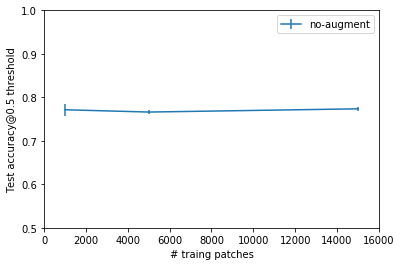

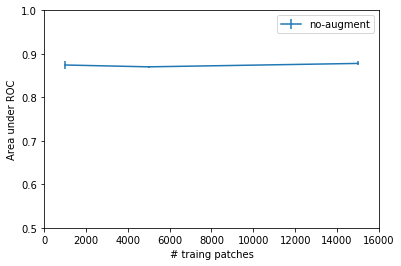

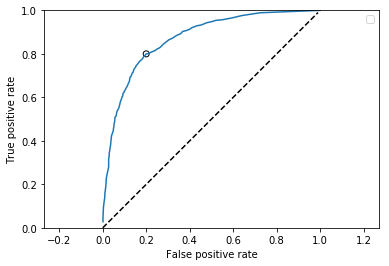

# positive train = 14353
# negative train = 42933
('MD589', 244)
('MD589', 295)


Feature for (MD589,295,(6688,448)) is not in pool. Re-compute.
Feature for (MD589,295,(6753,448)) is not in pool. Re-compute.
Feature for (MD589,295,(6818,448)) is not in pool. Re-compute.
Feature for (MD589,295,(6883,448)) is not in pool. Re-compute.
Feature for (MD589,295,(6948,448)) is not in pool. Re-compute.


('MD585', 182)


Feature for (MD585,182,(7143,448)) is not in pool. Re-compute.
Feature for (MD585,182,(7208,448)) is not in pool. Re-compute.
Feature for (MD585,182,(7273,448)) is not in pool. Re-compute.
Feature for (MD585,182,(7338,448)) is not in pool. Re-compute.
Feature for (MD585,182,(5388,448)) is not in pool. Re-compute.
Feature for (MD585,182,(5453,448)) is not in pool. Re-compute.
Feature for (MD585,182,(5518,448)) is not in pool. Re-compute.
Feature for (MD585,182,(5583,448)) is not in pool. Re-compute.
Feature for (MD585,182,(5648,448)) is not in pool. Re-compute.
Feature for (MD585,182,(5713,448)) is not in pool. Re-compute.
Feature for (MD585,182,(5778,448)) is not in pool. Re-compute.
Feature for (MD585,182,(5843,448)) is not in pool. Re-compute.
Feature for (MD585,182,(5908,448)) is not in pool. Re-compute.
Feature for (MD585,182,(6688,448)) is not in pool. Re-compute.
Feature for (MD585,182,(6753,448)) is not in pool. Re-compute.
Feature for (MD585,182,(6818,448)) is not in pool. Re-c

('MD589', 263)


Feature for (MD589,263,(6428,448)) is not in pool. Re-compute.
Feature for (MD589,263,(6493,448)) is not in pool. Re-compute.
Feature for (MD589,263,(6558,448)) is not in pool. Re-compute.


('MD585', 280)
('MD589', 273)
('MD589', 230)
('MD589', 251)
('MD589', 140)


Feature for (MD589,140,(7013,448)) is not in pool. Re-compute.
Feature for (MD589,140,(7078,448)) is not in pool. Re-compute.
Feature for (MD589,140,(7143,448)) is not in pool. Re-compute.
Feature for (MD589,140,(7208,448)) is not in pool. Re-compute.
Feature for (MD589,140,(7273,448)) is not in pool. Re-compute.
Feature for (MD589,140,(7338,448)) is not in pool. Re-compute.
Feature for (MD589,140,(7403,448)) is not in pool. Re-compute.
Feature for (MD589,140,(7468,448)) is not in pool. Re-compute.


('MD585', 224)


Feature for (MD585,224,(6883,1293)) is not in pool. Re-compute.
Feature for (MD585,224,(6948,1228)) is not in pool. Re-compute.
Feature for (MD585,224,(6948,1293)) is not in pool. Re-compute.
Feature for (MD585,224,(7013,1228)) is not in pool. Re-compute.
Feature for (MD585,224,(7013,1293)) is not in pool. Re-compute.
Feature for (MD585,224,(7078,1228)) is not in pool. Re-compute.


('MD585', 157)


Feature for (MD585,157,(5778,448)) is not in pool. Re-compute.
Feature for (MD585,157,(5843,448)) is not in pool. Re-compute.
Feature for (MD585,157,(5908,448)) is not in pool. Re-compute.
Feature for (MD585,157,(5973,448)) is not in pool. Re-compute.
Feature for (MD585,157,(6038,448)) is not in pool. Re-compute.
Feature for (MD585,157,(6103,448)) is not in pool. Re-compute.
Feature for (MD585,157,(6168,448)) is not in pool. Re-compute.
Feature for (MD585,157,(6233,448)) is not in pool. Re-compute.
Feature for (MD585,157,(6298,448)) is not in pool. Re-compute.
Feature for (MD585,157,(7013,448)) is not in pool. Re-compute.
Feature for (MD585,157,(7078,448)) is not in pool. Re-compute.
Feature for (MD585,157,(7143,448)) is not in pool. Re-compute.
Feature for (MD585,157,(7208,448)) is not in pool. Re-compute.
Feature for (MD585,157,(7273,448)) is not in pool. Re-compute.
Feature for (MD585,157,(7338,448)) is not in pool. Re-compute.
Feature for (MD585,157,(7403,448)) is not in pool. Re-c

('MD585', 170)


Feature for (MD585,170,(7143,448)) is not in pool. Re-compute.
Feature for (MD585,170,(7208,448)) is not in pool. Re-compute.
Feature for (MD585,170,(7273,448)) is not in pool. Re-compute.
Feature for (MD585,170,(7338,448)) is not in pool. Re-compute.
Feature for (MD585,170,(7403,448)) is not in pool. Re-compute.
Feature for (MD585,170,(5453,448)) is not in pool. Re-compute.
Feature for (MD585,170,(5518,448)) is not in pool. Re-compute.
Feature for (MD585,170,(5583,448)) is not in pool. Re-compute.
Feature for (MD585,170,(5648,448)) is not in pool. Re-compute.
Feature for (MD585,170,(5713,448)) is not in pool. Re-compute.
Feature for (MD585,170,(5778,448)) is not in pool. Re-compute.
Feature for (MD585,170,(5843,448)) is not in pool. Re-compute.
Feature for (MD585,170,(5908,448)) is not in pool. Re-compute.
Feature for (MD585,170,(5973,448)) is not in pool. Re-compute.
Feature for (MD585,170,(6038,448)) is not in pool. Re-compute.
Feature for (MD585,170,(6103,448)) is not in pool. Re-c

('MD589', 236)
('MD585', 156)


Feature for (MD585,156,(5778,448)) is not in pool. Re-compute.
Feature for (MD585,156,(5843,448)) is not in pool. Re-compute.
Feature for (MD585,156,(5908,448)) is not in pool. Re-compute.
Feature for (MD585,156,(5973,448)) is not in pool. Re-compute.
Feature for (MD585,156,(6038,448)) is not in pool. Re-compute.
Feature for (MD585,156,(6103,448)) is not in pool. Re-compute.
Feature for (MD585,156,(6168,448)) is not in pool. Re-compute.
Feature for (MD585,156,(6233,448)) is not in pool. Re-compute.
Feature for (MD585,156,(6298,448)) is not in pool. Re-compute.
Feature for (MD585,156,(6363,448)) is not in pool. Re-compute.
Feature for (MD585,156,(7078,448)) is not in pool. Re-compute.
Feature for (MD585,156,(7143,448)) is not in pool. Re-compute.
Feature for (MD585,156,(7208,448)) is not in pool. Re-compute.
Feature for (MD585,156,(7273,448)) is not in pool. Re-compute.
Feature for (MD585,156,(7338,448)) is not in pool. Re-compute.
Feature for (MD585,156,(7403,448)) is not in pool. Re-c

('MD589', 141)


Feature for (MD589,141,(6948,448)) is not in pool. Re-compute.
Feature for (MD589,141,(7013,448)) is not in pool. Re-compute.
Feature for (MD589,141,(7078,448)) is not in pool. Re-compute.
Feature for (MD589,141,(7143,448)) is not in pool. Re-compute.
Feature for (MD589,141,(7208,448)) is not in pool. Re-compute.
Feature for (MD589,141,(7273,448)) is not in pool. Re-compute.
Feature for (MD589,141,(7338,448)) is not in pool. Re-compute.
Feature for (MD589,141,(7403,448)) is not in pool. Re-compute.
Feature for (MD589,141,(7468,448)) is not in pool. Re-compute.
Feature for (MD589,141,(8703,448)) is not in pool. Re-compute.


('MD585', 136)
('MD589', 150)


Feature for (MD589,150,(6753,448)) is not in pool. Re-compute.
Feature for (MD589,150,(6818,448)) is not in pool. Re-compute.
Feature for (MD589,150,(6883,448)) is not in pool. Re-compute.
Feature for (MD589,150,(6948,448)) is not in pool. Re-compute.
Feature for (MD589,150,(7013,448)) is not in pool. Re-compute.
Feature for (MD589,150,(7078,448)) is not in pool. Re-compute.
Feature for (MD589,150,(7143,448)) is not in pool. Re-compute.
Feature for (MD589,150,(7208,448)) is not in pool. Re-compute.
Feature for (MD589,150,(7273,448)) is not in pool. Re-compute.
Feature for (MD589,150,(7338,448)) is not in pool. Re-compute.


('MD585', 256)


Feature for (MD585,256,(8573,448)) is not in pool. Re-compute.
Feature for (MD585,256,(8638,448)) is not in pool. Re-compute.
Feature for (MD585,256,(8703,448)) is not in pool. Re-compute.


('MD585', 251)


Feature for (MD585,251,(8508,448)) is not in pool. Re-compute.
Feature for (MD585,251,(8573,448)) is not in pool. Re-compute.
Feature for (MD585,251,(8638,448)) is not in pool. Re-compute.


('MD585', 240)


Feature for (MD585,240,(8378,448)) is not in pool. Re-compute.


# positive test = 7732
# negative test = 21332
('MD594', 185)


Feature for (MD594,185,(4543,448)) is not in pool. Re-compute.
Feature for (MD594,185,(4608,448)) is not in pool. Re-compute.
Feature for (MD594,185,(4673,448)) is not in pool. Re-compute.
Feature for (MD594,185,(4738,448)) is not in pool. Re-compute.
Feature for (MD594,185,(4803,448)) is not in pool. Re-compute.
Feature for (MD594,185,(4868,448)) is not in pool. Re-compute.
Feature for (MD594,185,(4933,448)) is not in pool. Re-compute.
Feature for (MD594,185,(4998,448)) is not in pool. Re-compute.
Feature for (MD594,185,(5063,448)) is not in pool. Re-compute.
Feature for (MD594,185,(5128,448)) is not in pool. Re-compute.
Feature for (MD594,185,(5193,448)) is not in pool. Re-compute.
Feature for (MD594,185,(5258,448)) is not in pool. Re-compute.
Feature for (MD594,185,(5323,448)) is not in pool. Re-compute.
Feature for (MD594,185,(5388,448)) is not in pool. Re-compute.
Feature for (MD594,185,(5453,448)) is not in pool. Re-compute.
Feature for (MD594,185,(5778,448)) is not in pool. Re-c

('MD594', 258)


Feature for (MD594,258,(4283,448)) is not in pool. Re-compute.
Feature for (MD594,258,(4348,448)) is not in pool. Re-compute.
Feature for (MD594,258,(4413,448)) is not in pool. Re-compute.
Feature for (MD594,258,(4478,448)) is not in pool. Re-compute.
Feature for (MD594,258,(4543,448)) is not in pool. Re-compute.
Feature for (MD594,258,(4608,448)) is not in pool. Re-compute.
Feature for (MD594,258,(4673,448)) is not in pool. Re-compute.
Feature for (MD594,258,(4738,448)) is not in pool. Re-compute.
Feature for (MD594,258,(4803,448)) is not in pool. Re-compute.
Feature for (MD594,258,(4868,448)) is not in pool. Re-compute.
Feature for (MD594,258,(4933,448)) is not in pool. Re-compute.
Feature for (MD594,258,(4998,448)) is not in pool. Re-compute.
Feature for (MD594,258,(5063,448)) is not in pool. Re-compute.
Feature for (MD594,258,(5388,448)) is not in pool. Re-compute.
Feature for (MD594,258,(5453,448)) is not in pool. Re-compute.
Feature for (MD594,258,(5518,448)) is not in pool. Re-c

('MD594', 283)


Feature for (MD594,283,(4348,448)) is not in pool. Re-compute.
Feature for (MD594,283,(4413,448)) is not in pool. Re-compute.
Feature for (MD594,283,(4478,448)) is not in pool. Re-compute.
Feature for (MD594,283,(4543,448)) is not in pool. Re-compute.
Feature for (MD594,283,(4608,448)) is not in pool. Re-compute.
Feature for (MD594,283,(4673,448)) is not in pool. Re-compute.
Feature for (MD594,283,(4738,448)) is not in pool. Re-compute.
Feature for (MD594,283,(4803,448)) is not in pool. Re-compute.
Feature for (MD594,283,(4868,448)) is not in pool. Re-compute.
Feature for (MD594,283,(4933,448)) is not in pool. Re-compute.
Feature for (MD594,283,(4998,448)) is not in pool. Re-compute.
Feature for (MD594,283,(5323,448)) is not in pool. Re-compute.
Feature for (MD594,283,(5388,448)) is not in pool. Re-compute.
Feature for (MD594,283,(5453,448)) is not in pool. Re-compute.
Feature for (MD594,283,(5518,448)) is not in pool. Re-compute.
Feature for (MD594,283,(5583,448)) is not in pool. Re-c

('MD594', 154)


Feature for (MD594,154,(6883,448)) is not in pool. Re-compute.
Feature for (MD594,154,(6948,448)) is not in pool. Re-compute.
Feature for (MD594,154,(7013,448)) is not in pool. Re-compute.
Feature for (MD594,154,(7208,448)) is not in pool. Re-compute.
Feature for (MD594,154,(7273,448)) is not in pool. Re-compute.
Feature for (MD594,154,(7338,448)) is not in pool. Re-compute.
Feature for (MD594,154,(7403,448)) is not in pool. Re-compute.
Feature for (MD594,154,(7468,448)) is not in pool. Re-compute.
Feature for (MD594,154,(7533,448)) is not in pool. Re-compute.
Feature for (MD594,154,(7598,448)) is not in pool. Re-compute.
Feature for (MD594,154,(7663,448)) is not in pool. Re-compute.


('MD594', 243)


Feature for (MD594,243,(5778,448)) is not in pool. Re-compute.
Feature for (MD594,243,(5843,448)) is not in pool. Re-compute.
Feature for (MD594,243,(5908,448)) is not in pool. Re-compute.
Feature for (MD594,243,(5973,448)) is not in pool. Re-compute.
Feature for (MD594,243,(6038,448)) is not in pool. Re-compute.
Feature for (MD594,243,(6103,448)) is not in pool. Re-compute.
Feature for (MD594,243,(6168,448)) is not in pool. Re-compute.
Feature for (MD594,243,(6233,448)) is not in pool. Re-compute.
Feature for (MD594,243,(6298,448)) is not in pool. Re-compute.
Feature for (MD594,243,(6363,448)) is not in pool. Re-compute.
Feature for (MD594,243,(6428,448)) is not in pool. Re-compute.
Feature for (MD594,243,(6493,448)) is not in pool. Re-compute.
Feature for (MD594,243,(6558,448)) is not in pool. Re-compute.
Feature for (MD594,243,(6623,448)) is not in pool. Re-compute.
Feature for (MD594,243,(6688,448)) is not in pool. Re-compute.
Feature for (MD594,243,(6753,448)) is not in pool. Re-c

('MD594', 169)


Feature for (MD594,169,(4868,448)) is not in pool. Re-compute.
Feature for (MD594,169,(5258,448)) is not in pool. Re-compute.
Feature for (MD594,169,(5323,448)) is not in pool. Re-compute.
Feature for (MD594,169,(5388,448)) is not in pool. Re-compute.
Feature for (MD594,169,(5583,448)) is not in pool. Re-compute.
Feature for (MD594,169,(5648,448)) is not in pool. Re-compute.
Feature for (MD594,169,(6103,448)) is not in pool. Re-compute.
Feature for (MD594,169,(6168,448)) is not in pool. Re-compute.
Feature for (MD594,169,(6233,448)) is not in pool. Re-compute.
Feature for (MD594,169,(6298,448)) is not in pool. Re-compute.
Feature for (MD594,169,(6363,448)) is not in pool. Re-compute.
Feature for (MD594,169,(6428,448)) is not in pool. Re-compute.
Feature for (MD594,169,(6493,448)) is not in pool. Re-compute.
Feature for (MD594,169,(6558,448)) is not in pool. Re-compute.
Feature for (MD594,169,(6623,448)) is not in pool. Re-compute.
Feature for (MD594,169,(6688,448)) is not in pool. Re-c

('MD594', 157)


Feature for (MD594,157,(6688,448)) is not in pool. Re-compute.
Feature for (MD594,157,(6753,448)) is not in pool. Re-compute.
Feature for (MD594,157,(6818,448)) is not in pool. Re-compute.
Feature for (MD594,157,(6883,448)) is not in pool. Re-compute.
Feature for (MD594,157,(6948,448)) is not in pool. Re-compute.
Feature for (MD594,157,(7013,448)) is not in pool. Re-compute.
Feature for (MD594,157,(7078,448)) is not in pool. Re-compute.
Feature for (MD594,157,(7143,448)) is not in pool. Re-compute.
Feature for (MD594,157,(7208,448)) is not in pool. Re-compute.
Feature for (MD594,157,(7273,448)) is not in pool. Re-compute.
Feature for (MD594,157,(7338,448)) is not in pool. Re-compute.
Feature for (MD594,157,(7403,448)) is not in pool. Re-compute.
Feature for (MD594,157,(7468,448)) is not in pool. Re-compute.
Feature for (MD594,157,(7533,448)) is not in pool. Re-compute.
Feature for (MD594,157,(7598,448)) is not in pool. Re-compute.
Feature for (MD594,157,(7663,448)) is not in pool. Re-c

('MD594', 235)


Feature for (MD594,235,(5583,448)) is not in pool. Re-compute.
Feature for (MD594,235,(5648,448)) is not in pool. Re-compute.
Feature for (MD594,235,(5713,448)) is not in pool. Re-compute.
Feature for (MD594,235,(5778,448)) is not in pool. Re-compute.
Feature for (MD594,235,(5843,448)) is not in pool. Re-compute.
Feature for (MD594,235,(5908,448)) is not in pool. Re-compute.
Feature for (MD594,235,(5973,448)) is not in pool. Re-compute.
Feature for (MD594,235,(6038,448)) is not in pool. Re-compute.
Feature for (MD594,235,(6103,448)) is not in pool. Re-compute.
Feature for (MD594,235,(6168,448)) is not in pool. Re-compute.
Feature for (MD594,235,(6233,448)) is not in pool. Re-compute.
Feature for (MD594,235,(6298,448)) is not in pool. Re-compute.
Feature for (MD594,235,(6363,448)) is not in pool. Re-compute.
Feature for (MD594,235,(6428,448)) is not in pool. Re-compute.
Feature for (MD594,235,(6493,448)) is not in pool. Re-compute.
Feature for (MD594,235,(6558,448)) is not in pool. Re-c

('MD594', 255)


Feature for (MD594,255,(4283,448)) is not in pool. Re-compute.
Feature for (MD594,255,(4348,448)) is not in pool. Re-compute.
Feature for (MD594,255,(4413,448)) is not in pool. Re-compute.
Feature for (MD594,255,(4478,448)) is not in pool. Re-compute.
Feature for (MD594,255,(4543,448)) is not in pool. Re-compute.
Feature for (MD594,255,(4608,448)) is not in pool. Re-compute.
Feature for (MD594,255,(4673,448)) is not in pool. Re-compute.
Feature for (MD594,255,(4738,448)) is not in pool. Re-compute.
Feature for (MD594,255,(4803,448)) is not in pool. Re-compute.
Feature for (MD594,255,(4868,448)) is not in pool. Re-compute.
Feature for (MD594,255,(4933,448)) is not in pool. Re-compute.
Feature for (MD594,255,(5323,448)) is not in pool. Re-compute.
Feature for (MD594,255,(5388,448)) is not in pool. Re-compute.
Feature for (MD594,255,(5453,448)) is not in pool. Re-compute.
Feature for (MD594,255,(5518,448)) is not in pool. Re-compute.
Feature for (MD594,255,(5583,448)) is not in pool. Re-c

('MD594', 160)


Feature for (MD594,160,(6818,448)) is not in pool. Re-compute.
Feature for (MD594,160,(6883,448)) is not in pool. Re-compute.
Feature for (MD594,160,(6948,448)) is not in pool. Re-compute.
Feature for (MD594,160,(7013,448)) is not in pool. Re-compute.
Feature for (MD594,160,(7078,448)) is not in pool. Re-compute.
Feature for (MD594,160,(7143,448)) is not in pool. Re-compute.
Feature for (MD594,160,(7208,448)) is not in pool. Re-compute.
Feature for (MD594,160,(7273,448)) is not in pool. Re-compute.
Feature for (MD594,160,(7338,448)) is not in pool. Re-compute.
Feature for (MD594,160,(7403,448)) is not in pool. Re-compute.
Feature for (MD594,160,(7468,448)) is not in pool. Re-compute.
Feature for (MD594,160,(7533,448)) is not in pool. Re-compute.


n_train 1000
Trial 0
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.45 seconds


Trial 1
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.45 seconds


Trial 2
Training: 1000 positive, 1000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 0.49 seconds


n_train 5000
Trial 0
Training: 5000 positive, 5000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 3.51 seconds


Trial 1
Training: 5000 positive, 5000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 3.81 seconds


Trial 2
Training: 5000 positive, 5000 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 3.38 seconds


n_train 15000
Trial 0
Training: 14353 positive, 14353 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 15.89 seconds


Trial 1
Training: 14353 positive, 14353 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 17.23 seconds


Trial 2
Training: 14353 positive, 14353 negative
Test: 1000 positive, 1000 negative


Fitting classifier: 16.86 seconds


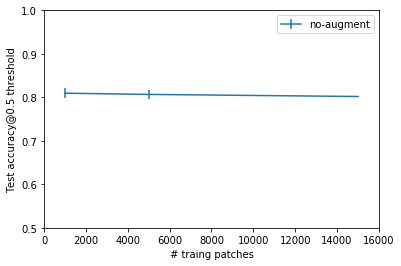

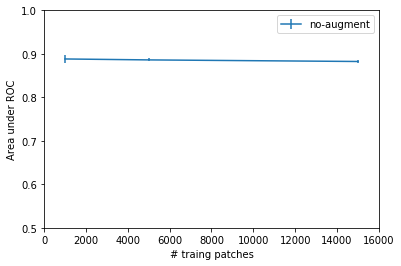

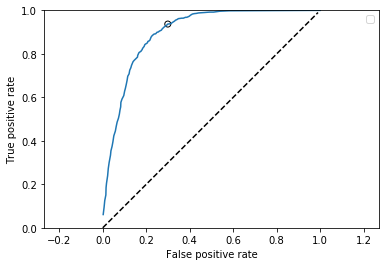

In [36]:
for structure in all_known_structures:
    if structure in ['SNC', '4N']:
        continue
# for structure in ['3N']:

    # features_dict = {(scheme, tfv): {} for scheme in schemes for tfv in transforms}
    features_dict = defaultdict(dict)

    ############## Sample and Load training feature vectors #########################################

    if extract_train_features:
    
        positive_addresses_traindata, negative_addresses_traindata = \
        sample_addresses(train_stacks, structure)

        print '# positive train =', len(positive_addresses_traindata)
        print '# negative train =', len(negative_addresses_traindata)

        addresses_to_compute = positive_addresses_traindata + negative_addresses_traindata

        for variant in [0]:
            features_loaded = read_features(addresses=addresses_to_compute, 
                                            scheme=train_scheme, win_id=win_id, prep_id=prep_id, 
                                            model=model, mean_img=mean_img, model_name=model_name, 
                                            batch_size=batch_size,
                                           method=method,
                                           compute_new_addresses=compute_new_addresses
                                           )
            
            for addr, f in izip(addresses_to_compute, features_loaded):
                if f is not None:
                    features_dict[(train_scheme, variant)][addr] = f

            del features_loaded

    ############## Sample and Load test feature vectors #############################################
    
    positive_addresses_testdata, negative_addresses_testdata = \
    sample_addresses(test_stacks, structure)
    
    print '# positive test =', len(positive_addresses_testdata)
    print '# negative test =', len(negative_addresses_testdata)
    
    addresses_to_compute = positive_addresses_testdata + negative_addresses_testdata

    for variant in [0]:
        features_loaded = read_features(addresses=addresses_to_compute, 
                                        scheme=test_scheme, win_id=win_id, prep_id=prep_id, 
                                        model=model, mean_img=mean_img, model_name=model_name, 
                                        batch_size=batch_size,
                                           method=method,
                                       compute_new_addresses=compute_new_addresses
                                       )

        for addr, f in izip(addresses_to_compute, features_loaded):
            if f is not None:
                features_dict[(test_scheme, variant)][addr] = f

        del features_loaded
            
    ########################################################################################
    
    # n_train_list = [10, 100, 200, 500, 1000, 2000, 5000, 10000, 15000]
#     n_train_list = [10, 1000]
    n_train_list = [1000, 5000, 15000]
#     n_train_list = [1000, 5000]
#     n_train_list = [15000]
    test_metrics_all_ntrain = defaultdict(lambda: defaultdict(list))
    train_metrics_all_ntrain = defaultdict(lambda: defaultdict(list))

    for n_train in n_train_list:

        print "n_train", n_train
        
        for trial in range(3):
            print "Trial", trial
            
            ##### Sample from training pool the required number of examples ######

            # If train and test data are from different sets
            n_train_pos = min(n_train, len(positive_addresses_traindata))
#             if len(positive_addresses_traindata) < n_train_pos:
#                 continue
            training_pos_indices = np.random.choice(range(len(positive_addresses_traindata)), n_train_pos, replace=False)
            
            n_test_pos = min(len(positive_addresses_testdata), 1000)
            test_pos_indices = np.random.choice(range(len(positive_addresses_testdata)), n_test_pos, replace=False)

            # If train and test are from same set
        #     n_pos_total = len(positive_addresses)
        #     n_train_pos = 1000
        #     training_pos_indices = np.random.choice(range(n_pos_total), n_train_pos, replace=False)
        #     test_pos_indices = np.random.choice(np.setdiff1d(range(n_pos_total), training_pos_indices),
        #                                         size=min(2000, n_pos_total-n_train_pos), replace=False)
        #     n_test_pos = len(test_pos_indices)

            # If train and test data are from different sets
            n_train_neg = n_train_pos
            training_neg_indices = np.random.choice(range(len(negative_addresses_traindata)), n_train_neg, replace=False)
            
            n_test_neg = min(len(negative_addresses_testdata), 1000)
            test_neg_indices = np.random.choice(range(len(negative_addresses_testdata)), n_test_neg, replace=False)

            # If train and test are from same set
        #     n_neg_total = len(negative_addresses)
        #     n_train_neg = 1000
        #     training_neg_indices = np.random.choice(range(n_neg_total), n_train_neg, replace=False)
        #     test_neg_indices = np.random.choice(np.setdiff1d(range(n_neg_total), training_neg_indices), 
        #                                         size=min(2000, n_pos_total-n_train_pos), replace=False)
        #     n_test_neg = len(test_neg_indices)

            print "Training: %d positive, %d negative" % (n_train_pos, n_train_neg)
            print "Test: %d positive, %d negative" % (n_test_pos, n_test_neg)

            ################

            if extract_train_features:
                # If train and test data are from different sets
                addresses_train_pos = [positive_addresses_traindata[i] for i in training_pos_indices]
                addresses_train_neg = [negative_addresses_traindata[i] for i in training_neg_indices]

            addresses_test_pos = [positive_addresses_testdata[i] for i in test_pos_indices]
            addresses_test_neg = [negative_addresses_testdata[i] for i in test_neg_indices]

            #################

#             for augment_training in [True, False]:
            for augment_training in [False]:
        
                feature_classifier_alg = 'lr'
#                 feature_classifier_alg = 'xgb2'
        #             feature_classifier_alg = 'lin_svc'
        #             feature_classifier_alg = 'lin_svc_calib'
                sample_weights = None   

                if extract_train_features:
            
                    if augment_training:
                        train_transforms = range(8)
                    else:
                        train_transforms = range(1)
                    features_train_pos = {(train_scheme, tf_variant): 
                                          [features_dict[(train_scheme, tf_variant)][addr] 
                                           for addr in addresses_train_pos 
                                           if addr in features_dict[(train_scheme, tf_variant)]]
                                              for tf_variant in train_transforms}
                    features_train_neg = {(train_scheme, tf_variant): 
                                          [features_dict[(train_scheme, tf_variant)][addr] 
                                           for addr in addresses_train_neg
                                           if addr in features_dict[(train_scheme, tf_variant)]]
                                              for tf_variant in train_transforms}

                    train_data = np.concatenate([np.r_[features_train_pos[(train_scheme,tf)], 
                                                       features_train_neg[(train_scheme,tf)]] 
                                                    for tf in train_transforms])
                    train_labels = np.concatenate([np.r_[np.ones((len(features_train_pos[(train_scheme,tf)]), )), 
                                                        -np.ones((len(features_train_neg[(train_scheme,tf)]), ))]
                                                  for tf in train_transforms])

                if existing_classifier_id is None:
                    clf = train_binary_classifier(train_data, train_labels,
                                       alg=feature_classifier_alg, 
                                       sample_weights=sample_weights)

    #                 del train_data, features_train_pos, features_train_neg

                    clf_fp = DataManager.get_classifier_filepath(classifier_id=classifier_id, structure=structure)
                    save_data(clf, clf_fp)
#                     upload_to_s3(clf_fp)
                else:
                    sys.stderr.write('Load existing classifiers %d\n' % existing_classifier_id)
                    clf = DataManager.load_classifiers(classifier_id=existing_classifier_id)[structure]
                
                ######################### Compute train metrics #########################
                
                if extract_train_features:
                    train_metrics = compute_classification_metrics(clf.predict_proba(train_data)[:,1], train_labels)
                    train_metrics_all_ntrain[n_train][(train_scheme, 'augment' if augment_training else 'no-augment')].append(train_metrics)
                
                ######################### Test ###############################
                
                test_transforms = range(1)
                features_test_pos = {(test_scheme, tf_variant): 
                                      [features_dict[(test_scheme, tf_variant)][addr] 
                                       for addr in addresses_test_pos
                                      if addr in features_dict[(test_scheme, tf_variant)]]
                                          for tf_variant in test_transforms}
                features_test_neg = {(test_scheme, tf_variant): 
                                      [features_dict[(test_scheme, tf_variant)][addr] 
                                       for addr in addresses_test_neg
                                      if addr in features_dict[(test_scheme, tf_variant)]]
                                          for tf_variant in test_transforms}
                
                test_data = np.concatenate([np.r_[features_test_pos[(test_scheme,tf_variant)], 
                                  features_test_neg[(test_scheme,tf_variant)]]
                                            for tf_variant in train_transforms])
                test_labels = np.concatenate([np.r_[np.ones((len(features_test_pos[(test_scheme,tf_variant)]), )), 
                                     -np.ones((len(features_test_neg[(test_scheme,tf_variant)]), ))]
                                            for tf_variant in train_transforms])
                test_metrics = compute_classification_metrics(clf.predict_proba(test_data)[:,1], test_labels)
    #             print "acc@0.5 = %.3f, acc@opt = %.3f, opt_thresh = %.3f, auroc = %.3f, auprc = %.3f" % \
    #             (test_metrics['acc'][0.5], test_metrics['acc'][test_metrics['opt_thresh']], test_metrics['opt_thresh'], test_metrics['auroc'], test_metrics['auprc'])

                test_metrics_all_ntrain[n_train][(test_scheme, 'augment' if augment_training else 'no-augment')].append(test_metrics)

    train_metrics_all_ntrain.default_factory = None
    test_metrics_all_ntrain.default_factory = None
    
    plot_result_wrt_ntrain(extract_one_metric(test_metrics_all_ntrain, 'acc', 0.5), ylabel='Test accuracy@0.5 threshold');
    plot_result_wrt_ntrain(extract_one_metric(test_metrics_all_ntrain, 'auroc'), ylabel='Area under ROC');

    plot_roc_curve(test_metrics_all_ntrain[1000][(test_scheme,
                  'no-augment')][0]['fp'], 
                   test_metrics_all_ntrain[1000][(test_scheme,
                  'no-augment')][0]['tp'], 
                  test_metrics_all_ntrain[1000][(test_scheme,
                  'no-augment')][0]['opt_thresh']);
    
    import uuid

    result = {
        'n_sections': stack_section_number,
        'stain': stack_stain,
        'train_stacks': train_stacks,
        'test_stacks': test_stacks,
        'test_scheme': test_scheme,
        'train_scheme': train_scheme,
        'train_metrics_all_ntrain': train_metrics_all_ntrain,
        'test_metrics_all_ntrain': test_metrics_all_ntrain,
        'structure': structure,
        'method': method,
        'classifier_id': existing_classifier_id if existing_classifier_id is not None else classifier_id
    }

    create_if_not_exists(ROOT_DIR + '/assessment_results_v4/')
    save_pickle(result, ROOT_DIR + '/assessment_results_v4/assessment_result_%s.pkl' % str(uuid.uuid1()).split('-')[0])

In [37]:
np.mean(extract_one_metric(test_metrics_all_ntrain, 'auroc')[15000][('none','no-augment')])

0.8824355850574825

In [ ]:
plot_result_wrt_ntrain(extract_one_metric(test_metrics_all_ntrain, 'acc', 0.5), ylabel='Test accuracy@0.5 threshold');
plot_result_wrt_ntrain(extract_one_metric(test_metrics_all_ntrain, 'auroc'), ylabel='Area under ROC');